<a href="https://colab.research.google.com/github/PJavvaji04/Projects/blob/main/Drug_Prescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import display, HTML, clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
data = pd.read_csv('drug.csv')

In [13]:
data.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [14]:
data[['rating','usefulCount']].describe()

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [16]:
uni = data.nunique()
print('--Unique Values in the Dataset--\n')
print(uni)

--Unique Values in the Dataset--

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64


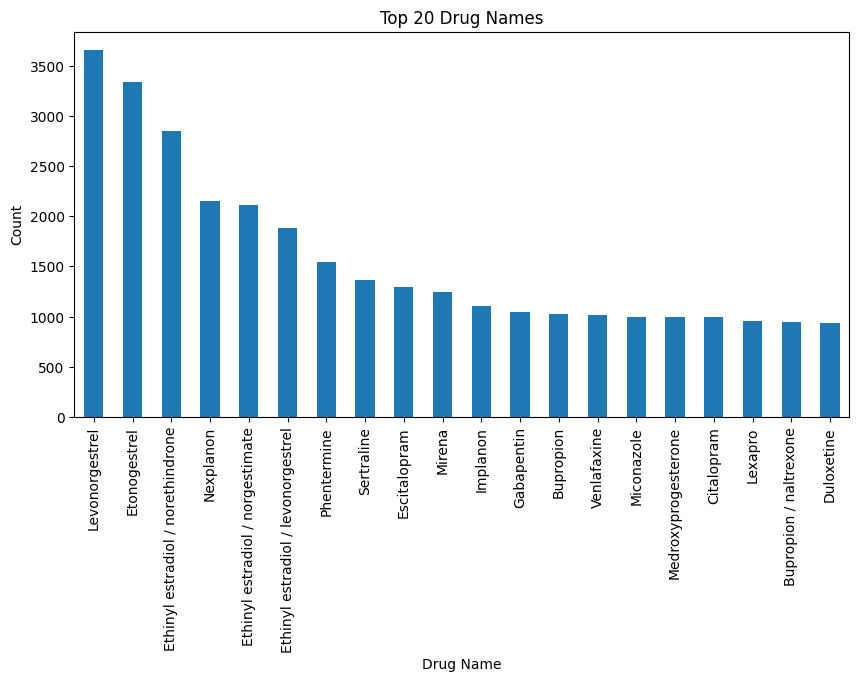

In [17]:
drug = data['drugName'].value_counts().head(20)
plt.figure(figsize=(10,5))
plt.title('Top 20 Drug Names')
drug.plot(kind='bar')
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.show()

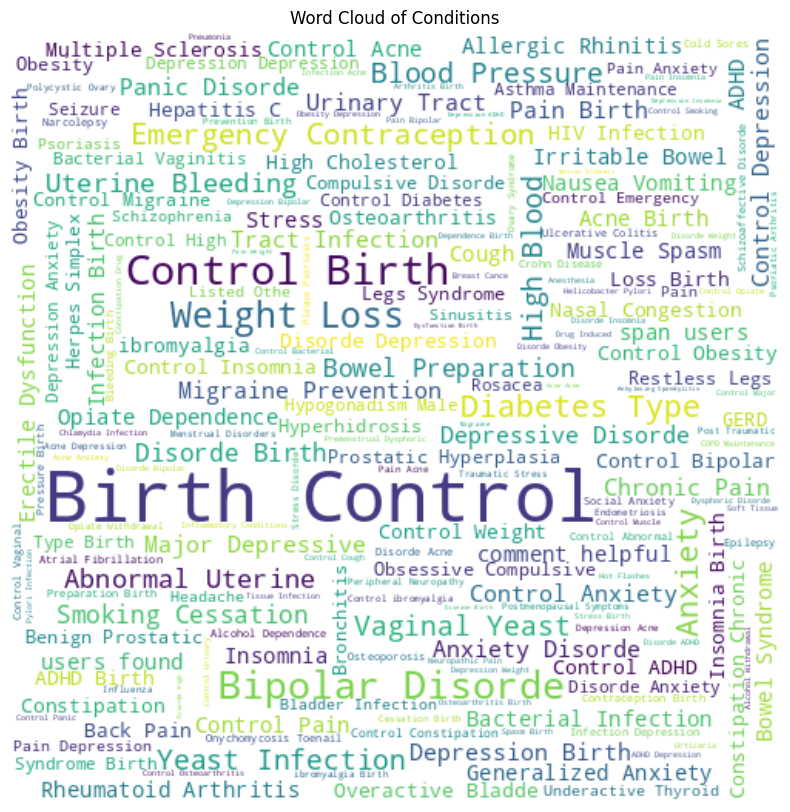

In [18]:
condi =" ".join(data['condition'].dropna().astype(str))

condi_cloud = WordCloud(width=500, height=500,background_color="white").generate(condi)
plt.figure(figsize=(20,10))
plt.title("Word Cloud of Conditions")
plt.imshow(condi_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()


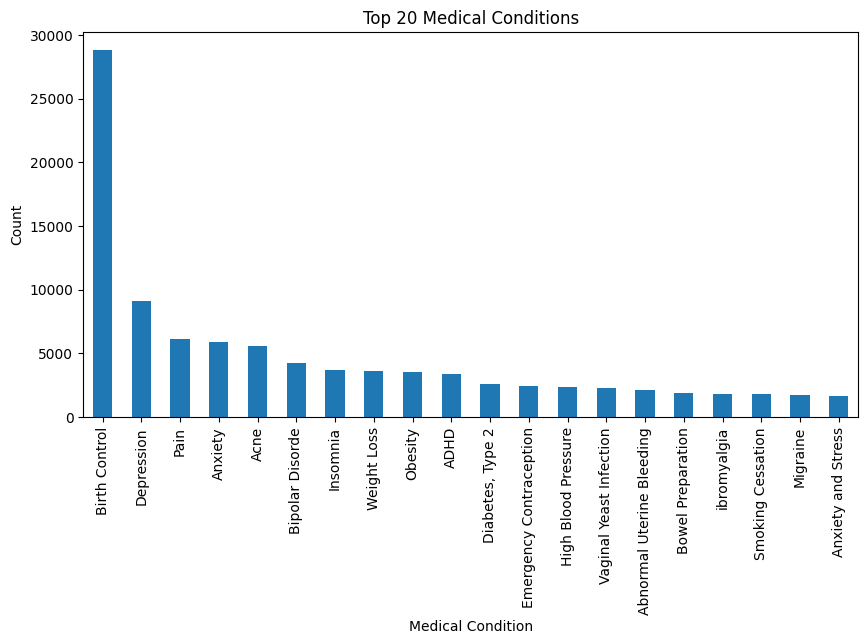

In [19]:
cond = data['condition'].value_counts().head(20)
plt.figure(figsize=(10,5))
plt.title('Top 20 Medical Conditions')
cond.plot(kind='bar')
plt.xlabel('Medical Condition')
plt.ylabel('Count')
plt.show()

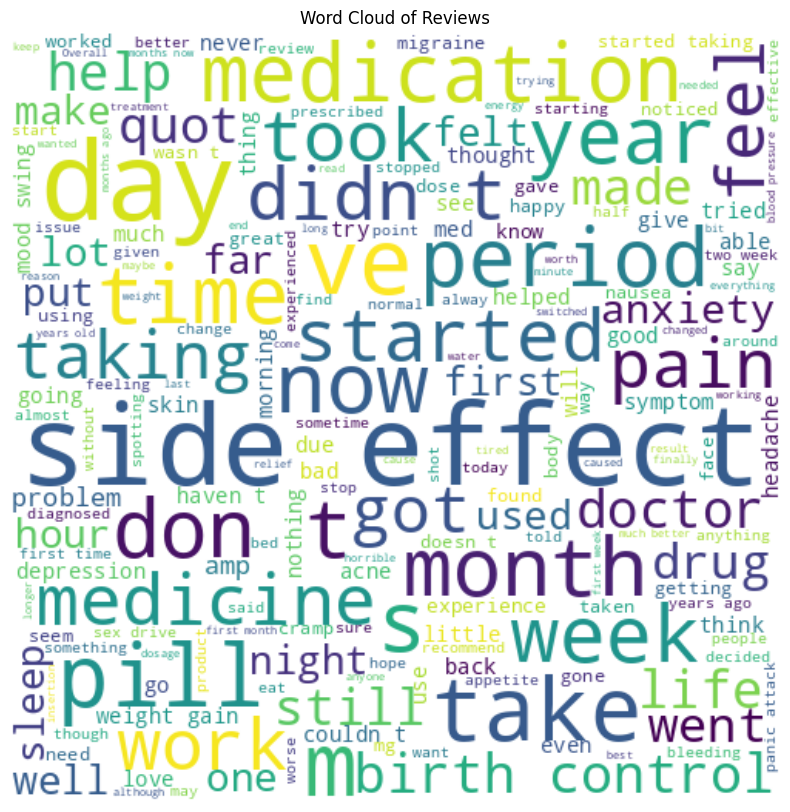

In [20]:

rev = " ".join(data['review'])

rev_cloud = WordCloud(width=500, height=500,background_color="White").generate(rev)

plt.figure(figsize=(20,10))
plt.imshow(rev_cloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()

In [21]:
data['review'] = data['review'].str.replace(r'[^\w\s]', '', regex=True)

In [22]:
data_cleaned = data.dropna(subset=['condition'])

In [23]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     160398 non-null  int64 
 1   drugName     160398 non-null  object
 2   condition    160398 non-null  object
 3   review       160398 non-null  object
 4   rating       160398 non-null  int64 
 5   date         160398 non-null  object
 6   usefulCount  160398 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 9.8+ MB


In [24]:
data_cleaned.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
161292,False
161293,False
161294,False
161295,False


In [25]:
# 2. Sentiment Analysis using VADER

In [26]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [27]:
# Make sure data_cleaned is a standalone copy
data_cleaned = data_cleaned.copy()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for each review using .loc
data_cleaned.loc[:, 'compound'] = data_cleaned['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Define a function to assign sentiment labels based on the compound score
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Create a new column with sentiment labels using .loc
data_cleaned.loc[:, 'sentiment'] = data_cleaned['compound'].apply(label_sentiment)


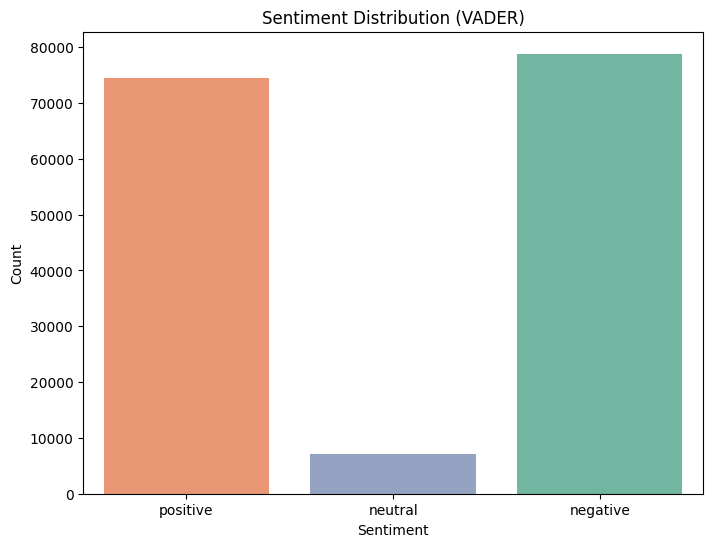

In [28]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='sentiment', data=data_cleaned, order=['positive', 'neutral', 'negative'], hue='sentiment', palette="Set2", dodge=False)
plt.title("Sentiment Distribution (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [29]:

# Prepare text data using TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(data_cleaned['review'])
y = data_cleaned['sentiment']



In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# --- (A) Logistic Regression Model ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8355049875311721
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

    negative       0.84      0.87      0.85     15753
     neutral       0.81      0.19      0.31      1438
    positive       0.83      0.86      0.85     14889

    accuracy                           0.84     32080
   macro avg       0.83      0.64      0.67     32080
weighted avg       0.83      0.84      0.83     32080



In [ ]:
# --- (B) Random Forest Classifier ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))



In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()




In [ ]:

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['positive','neutral','negative'])
plot_confusion_matrix(cm_lr, classes=['positive','neutral','negative'], title='Confusion Matrix: Logistic Regression')



In [ ]:

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['positive','neutral','negative'])
plot_confusion_matrix(cm_rf, classes=['positive','neutral','negative'], title='Confusion Matrix: Random Forest')

In [ ]:
# 4. Drug Recommendation

In [ ]:
# Ensure 'rating' is numeric
data_cleaned['rating'] = pd.to_numeric(data_cleaned['rating'], errors='coerce')


In [ ]:
drug_agg = data_cleaned.groupby(['condition', 'drugName']).agg({
    'rating': 'mean',
    'usefulCount': 'sum',
    'review': 'first'
}).reset_index()


In [ ]:
# HTML Widget Setup for Condition Search

In [ ]:
condition_input = widgets.Text(
    description='condition:',
    placeholder='Enter a medical condition'
)

In [ ]:
# Create a search button widget
search_button = widgets.Button(
    description='Search',
    button_style='primary'
)


In [ ]:


output = widgets.Output()


In [ ]:

# Function to handle search button click
def search_button_clicked(b):
    with output:
        clear_output()  # Clear previous output
        condition = condition_input.value.strip().lower()

        if condition == "":
            display(HTML("<h3>Please enter a condition.</h3>"))
            return

        # Filter dataset by condition (case-insensitive, partial match)
        drug_subset = drug_agg[drug_agg['condition'].str.lower().str.contains(condition, na=False)].copy()

        if drug_subset.empty:
            display(HTML(f"<h3>No records found for condition: {condition.capitalize()}</h3>"))
            return

        # Rank drugs by average rating (simple recommendation strategy)
        drug_subset = drug_subset.sort_values(by='rating', ascending=False)
        top5_drugs = drug_subset.head(5)

        # Display the top 5 drugs in an HTML table (showing condition, drugName, rating, usefulCount, and review)
        display(HTML(f"<h3>Top 5 Drugs for Condition: {condition.capitalize()}</h3>"))
        display(HTML(top5_drugs[['condition', 'drugName', 'rating', 'usefulCount', 'review']].to_html(index=False)))



In [ ]:
# Bind the search button to the click event
search_button.on_click(search_button_clicked)

display(condition_input, search_button, output)
